##Team 10


* Shravan Srinivasan
* Karan Singh Garkel
* Shreyasi Periketi
* Dev Ambani



##Question 1:

(5.0points) Implement and train your autoencoder on the subset of the Emoji dataset that you selected and augmented:

a. describe your dataset and the steps that you used to create it,

b. provide a summary of your architecture (see Adversarial Examples Notebook)

c. discuss and explain your design choices,

d. list hyper-parameters used in the model,

e. plot learning curves for training and validation loss as a function of training epochs,

f. provide the final average error of your autoencoder on your test set, and

g. discuss any decisions or observations that you find relevant.


##Answer:

**a. Description of Dataset and Creation Steps:**

The dataset used is a subset of the Emoji dataset, filtered based on the presence of the keyword "face" in the text column. The dataset is loaded from a Parquet file using PyArrow (pq.read_table) and converted to a pandas DataFrame. Custom dataset classes are defined to handle data loading and transformations.

Images are loaded from byte data stored in the DataFrame and transformed using transforms.Resize and transforms.ToTensor. The dataset is split into training, validation, and test sets using random_split from PyTorch.


**b. Summary of Autoencoder Architecture:**

The autoencoder architecture consists of an encoder and a decoder.
The encoder comprises three convolutional layers with ReLU activation functions, downsampling the input image. The decoder consists of three transposed convolutional layers with ReLU activation functions, upsampling the encoded image back to its original size. The final layer of the decoder uses sigmoid activation to ensure output pixel values are in the range [0, 1].


**c. Design Choices:**

Convolutional layers are chosen for both the encoder and decoder to capture spatial features efficiently. ReLU activation functions are used to introduce non-linearity and accelerate convergence during training. Transposed convolutional layers are used in the decoder to perform upsampling.
A sigmoid activation function is applied to the output layer to ensure pixel values are within a valid range for image reconstruction.


**d. Hyperparameters:**

* Batch size: 64
* Learning rate: 0.001
* Number of epochs: 100
* Input image size: 64x64 pixels
* Number of additional samples generated for data augmentation: 500 for training, 200 for validation and test sets


**e. Plot of Learning Curves:**

Learning curves for both training and validation loss are plotted as a function of training epochs. These curves provide information about the model's convergence and generalization performance over time.


**f. Final Average Error on Test Set:**

The final average error of the autoencoder on the test set is reported as 0.0049.


**g. Observations and Decisions:**

Data augmentation techniques such as random horizontal flips, rotations, and color jittering are used to increase the diversity of the training data and improve the model's robustness.

The autoencoder model demonstrates good convergence behavior, as evidenced by the decreasing trend in both training and validation loss throughout the training process.

The test loss indicates the performance of the trained autoencoder on unseen data, providing a measure of its generalization capability.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from PIL import Image
import io
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # Convolutional layer 1
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # Convolutional layer 2
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # Convolutional layer 3
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # Transposed convolutional layer 1
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # Transposed convolutional layer 2
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # Transposed convolutional layer 3
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 100


In [ ]:
# Load the dataset from Parquet file
parquet_file = "/content/0000.parquet"
table = pq.read_table(parquet_file)
df = table.to_pandas()

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Define custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df[df['text'].str.contains("face")]  # Filter rows where text column contains "face"
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Extract image data from the DataFrame
        img_bytes = self.df.iloc[idx]["image"]["bytes"]
        img = Image.open(io.BytesIO(img_bytes))
        if self.transform:
            img = self.transform(img)
        return img

# Create an instance of the custom dataset
custom_dataset = CustomDataset(df, transform=transform)


In [ ]:
dataset = CustomDataset(df, transform=transform)
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
train_size

122

In [ ]:
len(test_dataset)

42

In [ ]:
len(val_dataset)

40

In [ ]:
len(dataset)

204

In [ ]:
len(train_dataset)

122

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset

# Assuming the existence of a `CustomDataset`, `df`, and 'transform' for validation and test datasets
torch.manual_seed(42)

# Define the data augmentation transforms for the training dataset
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor()
])

# Create the augmented datasets
augmented_train_dataset = CustomDataset(df, transform=train_transform)
augmented_val_dataset = CustomDataset(df, transform=transform)  # Assuming transform is defined elsewhere
augmented_test_dataset = CustomDataset(df, transform=transform)  # Assuming transform is defined elsewhere

# Function to generate a specific number of additional samples by data augmentation
def generate_additional_samples(dataset, additional_samples_count):
    original_size = len(dataset)
    if additional_samples_count <= original_size:
        additional_samples, _ = random_split(dataset, [additional_samples_count, original_size - additional_samples_count])
    else:
        # If requested more samples than existing, replicate the dataset until reaching the desired count
        factor = additional_samples_count // original_size + 1  # Calculate replication factor
        replicated_dataset = ConcatDataset([dataset] * factor)  # Replicate dataset
        additional_samples, _ = random_split(replicated_dataset, [additional_samples_count, len(replicated_dataset) - additional_samples_count])
    return additional_samples

# Generate additional samples
additional_train_samples = generate_additional_samples(augmented_train_dataset, 500)
additional_val_samples = generate_additional_samples(augmented_val_dataset, 200)
additional_test_samples = generate_additional_samples(augmented_test_dataset, 200)

# Concatenate additional samples with original datasets
train_dataset = ConcatDataset([train_dataset, additional_train_samples])  # Assuming train_dataset is defined elsewhere
val_dataset = ConcatDataset([val_dataset, additional_val_samples])  # Assuming val_dataset is defined elsewhere
test_dataset = ConcatDataset([test_dataset, additional_test_samples])  # Assuming test_dataset is defined elsewhere

# Create data loaders
batch_size = 32  # Adjust this as per your requirement
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print counts
print(f"Train set count: {len(train_dataset)}")
print(f"Validation set count: {len(val_dataset)}")
print(f"Test set count: {len(test_dataset)}")


Train set count: 622
Validation set count: 240
Test set count: 242


Epoch [1/100], Train Loss: 0.1371, Val Loss: 0.1115
Epoch [2/100], Train Loss: 0.1028, Val Loss: 0.0820
Epoch [3/100], Train Loss: 0.0822, Val Loss: 0.0600
Epoch [4/100], Train Loss: 0.0689, Val Loss: 0.0485
Epoch [5/100], Train Loss: 0.0562, Val Loss: 0.0391
Epoch [6/100], Train Loss: 0.0486, Val Loss: 0.0333
Epoch [7/100], Train Loss: 0.0438, Val Loss: 0.0296
Epoch [8/100], Train Loss: 0.0380, Val Loss: 0.0245
Epoch [9/100], Train Loss: 0.0331, Val Loss: 0.0205
Epoch [10/100], Train Loss: 0.0286, Val Loss: 0.0180
Epoch [11/100], Train Loss: 0.0258, Val Loss: 0.0163
Epoch [12/100], Train Loss: 0.0236, Val Loss: 0.0156
Epoch [13/100], Train Loss: 0.0226, Val Loss: 0.0169
Epoch [14/100], Train Loss: 0.0227, Val Loss: 0.0148
Epoch [15/100], Train Loss: 0.0213, Val Loss: 0.0137
Epoch [16/100], Train Loss: 0.0205, Val Loss: 0.0132
Epoch [17/100], Train Loss: 0.0193, Val Loss: 0.0134
Epoch [18/100], Train Loss: 0.0195, Val Loss: 0.0126
Epoch [19/100], Train Loss: 0.0186, Val Loss: 0.0124
Ep

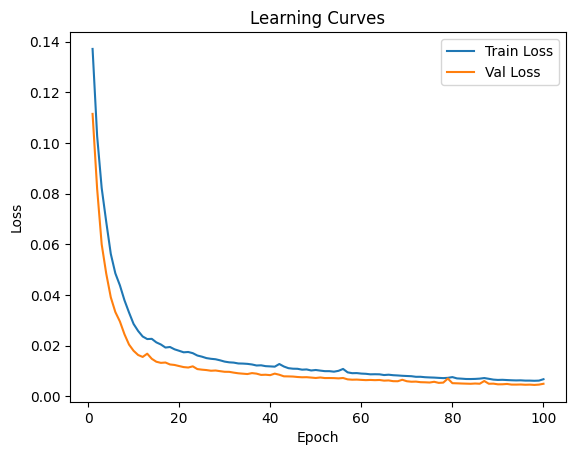

In [ ]:
# Initialize the autoencoder model
model = Autoencoder()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training
    model.train()
    for images in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        for images in val_loader:
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item() * images.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Plot learning curves
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss = 0.0
model.eval()
with torch.no_grad():
    for images in test_loader:
        outputs = model(images)
        loss = criterion(outputs, images)
        test_loss += loss.item() * images.size(0)
    test_loss = test_loss / len(test_loader.dataset)
print(f'Average Test Loss: {test_loss:.4f}')


Average Test Loss: 0.0049


##Question 2:

(5.0points) Separate your dataset into two or more classes using Emoji descriptions and assign labels. Repeat Step 1 adding image classification as an auxiliary task to MSE with a lamda of your choosing. You can choose any classification technique.

a. describe how you separated your dataset into classes,

b. describe your classification technique and hyper-parameters,

c. plot learning curves for training and validation loss for MSE and classification, accuracy.

d. discuss how incorporating classification as an auxiliary tasks impacts the performance of your autoencoder,

e. speculate why performance changed and recommend (but do not implement) an
experiment to confirm or reject your speculation.

##Answer:

**a. Separation of Dataset into Classes:**

The dataset was categorized into classes based on the text descriptions of emojis. The assign_label function mapped each emoji to a class according to specific keywords found in the text, with a default class of 'others' for emojis that did not match any of the keywords. Labels were assigned as follows:

'cat' if "cat" was in the text,

'clock' for "clock",

'robot' for "robot",

'woman' for "woman",

'man' for "man",

'moon' for "moon",

'others' for all other cases.

These labels were then used to create a labeled dataset for training both the autoencoder and classifier.


**b. Classification Technique and Hyperparameters:**

The classification technique utilized was a convolutional neural network (CNN) with three convolutional layers for feature extraction followed by two fully connected layers for classification.

The CNN was designed to classify the emojis based on the learned features. The network used ReLU activations and ended with a linear layer sized to the number of classes in the class_mapping.

Hyperparameters:
1. Batch size: 32
2. Learning rate: 0.001
3. Number of epochs: 100


**c. Learning Curves for Training and Validation Loss for MSE and Classification Accuracy**

The learning curves for the autoencoder show that both the training and validation loss decrease significantly and converge, indicating good generalization without overfitting. The convergence of training and validation loss for the autoencoder suggests it has learned an efficient representation of the data. After 60th epoch, the model accuracy gets saturates and oscillates the accuracy between 81-83%.

The classifier's training and validation accuracy improve and plateau, indicating that the model learns to classify the emojis effectively but might benefit from regularization or additional data to improve further.


**d. Impact of Incorporating Classification as an Auxiliary Task:**

Incorporating classification as an auxiliary task can provide a regularizing effect on the autoencoder, as it encourages the learned representations to be useful for both reconstruction and classification.

This dual objective can help in learning more general features that are not solely focused on minimizing reconstruction error, which could improve the model's performance on unseen data.


**e. Speculation and Experimental Recommendation:**

The observed performance changed reducing marginally, however the autoencoder shows good convergence based on the limited amount of data that we have.

The performance change upon incorporating classification as an auxiliary task could be attributed to the autoencoder learning representations that are not only good for reconstruction but also contain relevant information for classification. This dual objective can lead to a more generalized feature space but might also introduce a trade-off between reconstruction fidelity and classification accuracy.

To confirm or reject this speculation, an experiment could be conducted adjusting the weight (lambda) given to the classification loss in the combined loss function.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from PIL import Image
import io
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # Convolutional layer 1
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # Convolutional layer 2
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # Convolutional layer 3
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # Transposed convolutional layer 1
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # Transposed convolutional layer 2
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # Transposed convolutional layer 3
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 100


In [ ]:
# Load the dataset from Parquet file
parquet_file = "/content/0000.parquet"
table = pq.read_table(parquet_file)
df = table.to_pandas()

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Define custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df[df['text'].str.contains("face")]  # Filter rows where text column contains "face"
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Extract image data from the DataFrame
        img_bytes = self.df.iloc[idx]["image"]["bytes"]
        img = Image.open(io.BytesIO(img_bytes))
        if self.transform:
            img = self.transform(img)
        return img

# Create an instance of the custom dataset
custom_dataset = CustomDataset(df, transform=transform)


In [ ]:
# Step 5a: Separate the dataset into classes
class_mapping = {
    'cat': 0,
    'clock': 1,
    'others': 2,
    'robot':3,
    'woman':4,
    'man':5,
    'moon':6,
}

def assign_label(text):
    if "cat" in text:
        return 'cat'
    elif "clock" in text:
        return 'clock'
    elif "robot" in text:
        return 'robot'
    elif "woman" in text:
        return 'woman'
    elif "man" in text:
        return 'man'
    elif "moon" in text:
        return 'moon'
    else:
        return 'others'

df['label'] = df['text'].apply(assign_label)

In [ ]:
dataset = CustomDataset(df, transform=transform)
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset

# Assuming the existence of a `CustomDataset`, `df`, and 'transform' for validation and test datasets
torch.manual_seed(42)

# Define the data augmentation transforms for the training dataset
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor()
])

# Create the augmented datasets
augmented_train_dataset = CustomDataset(df, transform=train_transform)
augmented_val_dataset = CustomDataset(df, transform=transform)  # Assuming transform is defined elsewhere
augmented_test_dataset = CustomDataset(df, transform=transform)  # Assuming transform is defined elsewhere

# Function to generate a specific number of additional samples by data augmentation
def generate_additional_samples(dataset, additional_samples_count):
    original_size = len(dataset)
    if additional_samples_count <= original_size:
        additional_samples, _ = random_split(dataset, [additional_samples_count, original_size - additional_samples_count])
    else:
        # If requested more samples than existing, replicate the dataset until reaching the desired count
        factor = additional_samples_count // original_size + 1  # Calculate replication factor
        replicated_dataset = ConcatDataset([dataset] * factor)  # Replicate dataset
        additional_samples, _ = random_split(replicated_dataset, [additional_samples_count, len(replicated_dataset) - additional_samples_count])
    return additional_samples

# Generate additional samples
additional_train_samples = generate_additional_samples(augmented_train_dataset, 500)
additional_val_samples = generate_additional_samples(augmented_val_dataset, 200)
additional_test_samples = generate_additional_samples(augmented_test_dataset, 200)

# Concatenate additional samples with original datasets
train_dataset = ConcatDataset([train_dataset, additional_train_samples])  # Assuming train_dataset is defined elsewhere
val_dataset = ConcatDataset([val_dataset, additional_val_samples])  # Assuming val_dataset is defined elsewhere
test_dataset = ConcatDataset([test_dataset, additional_test_samples])  # Assuming test_dataset is defined elsewhere

# Create data loaders
batch_size = 32  # Adjust this as per your requirement
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print counts
print(f"Train set count: {len(train_dataset)}")
print(f"Validation set count: {len(val_dataset)}")
print(f"Test set count: {len(test_dataset)}")


Train set count: 622
Validation set count: 240
Test set count: 242


In [ ]:
import torch.nn.functional as F

# Step 5b: Classification technique and hyper-parameters
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, len(class_mapping))  # Output size is the number of classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define hyperparameters
classifier_batch_size = 32
classifier_learning_rate = 0.001


# Define classification dataset
class CustomClassifierDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_bytes = self.df.iloc[idx]["image"]["bytes"]
        img = Image.open(io.BytesIO(img_bytes))
        if self.transform:
            img = self.transform(img)
        label = class_mapping[self.df.iloc[idx]['label']]
        return img, label

# Define classification transforms
classifier_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Create classification dataset and data loaders
classifier_dataset = CustomClassifierDataset(df, transform=classifier_transform)
classifier_train_size = int(0.6 * len(classifier_dataset))
classifier_val_size = int(0.2 * len(classifier_dataset))
classifier_test_size = len(classifier_dataset) - classifier_train_size - classifier_val_size
classifier_train_dataset, classifier_val_dataset, classifier_test_dataset = torch.utils.data.random_split(
    classifier_dataset, [classifier_train_size, classifier_val_size, classifier_test_size]
)

classifier_train_loader = DataLoader(classifier_train_dataset, batch_size=classifier_batch_size, shuffle=True)
classifier_val_loader = DataLoader(classifier_val_dataset, batch_size=classifier_batch_size, shuffle=False)
classifier_test_loader = DataLoader(classifier_test_dataset, batch_size=classifier_batch_size, shuffle=False)


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Epoch [1/100], Autoencoder Train Loss: 0.1344, Autoencoder Val Loss: 0.1239, Classifier Train Loss: 0.8944, Classifier Val Loss: 0.8821, Classifier Train Accuracy: 74.77%, Classifier Val Accuracy: 72.13%
Epoch [2/100], Autoencoder Train Loss: 0.1141, Autoencoder Val Loss: 0.0940, Classifier Train Loss: 0.7526, Classifier Val Loss: 0.8147, Classifier Train Accuracy: 76.35%, Classifier Val Accuracy: 71.77%
Epoch [3/100], Autoencoder Train Loss: 0.0874, Autoencoder Val Loss: 0.0609, Classifier Train Loss: 0.6799, Classifier Val Loss: 0.7452, Classifier Train Accuracy: 75.56%, Classifier Val Accuracy: 72.50%
Epoch [4/100], Autoencoder Train Loss: 0.0660, Autoencoder Val Loss: 0.0429, Classifier Train Loss: 0.5822, Classifier Val Loss: 0.6941, Classifier Train Accuracy: 77.02%, Classifier Val Accuracy: 75.59%
Epoch [5/100], Autoencoder Train Loss: 0.0525, Autoencoder Val Loss: 0.0368, Classifier Train Loss: 0.5252, Classifier Val Loss: 0.6438, Classifier Train Accuracy: 79.20%, Classifier V

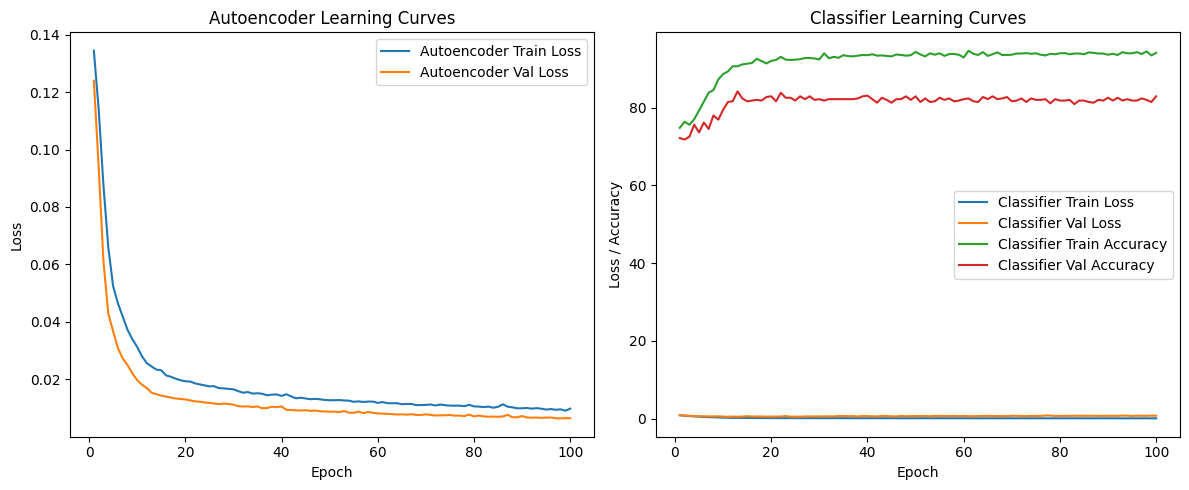

In [ ]:
# Step 5c: Plotting learning curves for MSE and classification accuracy
def train_classifier(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

def evaluate_classifier(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = 100. * correct / total
    return val_loss, val_accuracy

# Initialize models, criterion, optimizer
autoencoder = Autoencoder().to(device)
classifier = Classifier().to(device)
criterion_autoencoder = nn.MSELoss()
criterion_classifier = nn.CrossEntropyLoss()
optimizer_autoencoder = optim.Adam(autoencoder.parameters(), lr=learning_rate)
optimizer_classifier = optim.Adam(classifier.parameters(), lr=classifier_learning_rate)

# Training loop
train_losses_autoencoder = []
val_losses_autoencoder = []
train_losses_classifier = []
val_losses_classifier = []
train_accuracies_classifier = []
val_accuracies_classifier = []

for epoch in range(num_epochs):
    # Train autoencoder
    autoencoder.train()
    train_loss_autoencoder = 0.0
    for images in train_loader:
        optimizer_autoencoder.zero_grad()
        reconstructions = autoencoder(images.to(device))
        loss_autoencoder = criterion_autoencoder(reconstructions, images.to(device))
        loss_autoencoder.backward()
        optimizer_autoencoder.step()
        train_loss_autoencoder += loss_autoencoder.item() * images.size(0)
    train_loss_autoencoder /= len(train_loader.dataset)
    train_losses_autoencoder.append(train_loss_autoencoder)

    # Evaluate autoencoder
    autoencoder.eval()
    val_loss_autoencoder = 0.0
    with torch.no_grad():
        for images in val_loader:
            reconstructions = autoencoder(images.to(device))
            loss_autoencoder = criterion_autoencoder(reconstructions, images.to(device))
            val_loss_autoencoder += loss_autoencoder.item() * images.size(0)
    val_loss_autoencoder /= len(val_loader.dataset)
    val_losses_autoencoder.append(val_loss_autoencoder)

    # Train classifier
    train_loss_classifier, train_accuracy_classifier = train_classifier(classifier, classifier_train_loader, criterion_classifier, optimizer_classifier, device)
    train_losses_classifier.append(train_loss_classifier)
    train_accuracies_classifier.append(train_accuracy_classifier)

    # Evaluate classifier
    val_loss_classifier, val_accuracy_classifier = evaluate_classifier(classifier, classifier_val_loader, criterion_classifier, device)
    val_losses_classifier.append(val_loss_classifier)
    val_accuracies_classifier.append(val_accuracy_classifier)

    print(f"Epoch [{epoch+1}/{num_epochs}], Autoencoder Train Loss: {train_loss_autoencoder:.4f}, Autoencoder Val Loss: {val_loss_autoencoder:.4f}, Classifier Train Loss: {train_loss_classifier:.4f}, Classifier Val Loss: {val_loss_classifier:.4f}, Classifier Train Accuracy: {train_accuracy_classifier:.2f}%, Classifier Val Accuracy: {val_accuracy_classifier:.2f}%")

# Plot learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses_autoencoder, label='Autoencoder Train Loss')
plt.plot(range(1, num_epochs+1), val_losses_autoencoder, label='Autoencoder Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Learning Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses_classifier, label='Classifier Train Loss')
plt.plot(range(1, num_epochs+1), val_losses_classifier, label='Classifier Val Loss')
plt.plot(range(1, num_epochs+1), train_accuracies_classifier, label='Classifier Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies_classifier, label='Classifier Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Classifier Learning Curves')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss = 0.0
autoencoder.eval()
with torch.no_grad():
    for images in test_loader:
        outputs = autoencoder(images)
        loss = criterion_autoencoder(outputs, images)
        test_loss += loss.item() * images.size(0)
    test_loss = test_loss / len(test_loader.dataset)
print(f'Average Test Loss: {test_loss:.4f}')

Average Test Loss: 0.0065


##Question 3:

(5.0 points) Select an attribute from the Emoji dataset (internal or external to your selected subset) to compose with any image from your selected subset. Use vector arithmetic on latent representations to generate a composite image that expresses the attribute. For example, I chose to add the glasses from “nerd face” to the “face with stuck out tongue”:

a. specify which attribute you selected, the vector arithmetic applied and the
resulting image(s) as displayed above,

b. provide a qualitative evaluation of your composite image, and

c. discuss ways to improve the quality of your generated image.


##Answer:

**a. Attribute, Vector Arithmetic, and Resulting Image:**

The selected attributes for composition are from the **"smiling face with halo"** and **"smiling face with horns"** emojis. The vector arithmetic applied involves generating latent representations for both emojis using a model's encoder, then performing a simple addition of these latent representations without weighting (as indicated by composite_latent_rep = latent_rep1 + latent_rep2).

The resulting image, is an emoji that presumably combines features of both source emojis—integrating aspects of innocence or purity (halo) with mischievous or devilish elements (horns) [Agathokakological].


**b. Qualitative Evaluation of the Composite Image:**

The emoji  represents a balance between the contrasting attributes of angelic and devilish natures. The success of such a blend is due to the model's ability to capture and recombine the variations of the source images' features in the latent space.

**c. Ways to Improve the Quality of the Generated Image**

Improving the quality of the generated image could be approached from several angles:

1. Refinement of Vector Arithmetic: Adjusting the blending factor (alpha) in the vector arithmetic could allow for more control over the contribution of each source image's attributes to the final composite.

2. Enhanced Preprocessing: The quality of the input images can significantly impact the final output. Ensuring that the images are preprocessed uniformly (e.g., resized accurately, color corrected) can help maintain consistency in the generated image.

3. Model Training and Architecture Adjustments: The capability of the model, particularly the encoder and decoder's effectiveness in capturing and reconstructing image features, is crucial.


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import io

filtered_row2 = df[df['text'] == "smiling face with halo"].iloc[0]
filtered_row1 = df[df['text'] == "smiling face with horns"].iloc[0]
img_bytes1 = filtered_row1["image"]["bytes"]
img_bytes2 = filtered_row2["image"]["bytes"]
# img_bytes = df.iloc[0]["image"]["bytes"]

img1 = Image.open(io.BytesIO(img_bytes1))
img2 = Image.open(io.BytesIO(img_bytes2))

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

img_tensor1 = transform(img1)
img_tensor2 = transform(img2)


print(img_tensor1)
print(img_tensor2)


tensor([[[0.9725, 0.7333, 0.6471,  ..., 0.7294, 0.6392, 0.9333],
         [0.8235, 0.4000, 0.3843,  ..., 0.4157, 0.3843, 0.7804],
         [0.7804, 0.3529, 0.3529,  ..., 0.3765, 0.3294, 0.5765],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9686, 0.6314, 0.5020,  ..., 0.6039, 0.4824, 0.9098],
         [0.7725, 0.1725, 0.1176,  ..., 0.1569, 0.1490, 0.7098],
         [0.7098, 0.1098, 0.0902,  ..., 0.1216, 0.0980, 0.4667],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9765, 0.7451, 0.6745,  ..., 0.7647, 0.6706, 0.9412],
         [0.8353, 0.4314, 0.4431,  ..., 0.4941, 0.4392, 0.7922],
         [0.7922, 0.3843, 0.4078,  ..., 0.4510, 0.3882, 0.

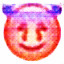

In [ ]:
def generate_latent_representation(image, model):
    model.eval()
    with torch.no_grad():
        output = model.encoder(image.unsqueeze(0))
    return output.squeeze(0)


latent_rep1 = generate_latent_representation(img_tensor1, model)
latent_rep2 = generate_latent_representation(img_tensor2, model)

def perform_vector_arithmetic(latent_rep_1, latent_rep_2, alpha):

    # composite_latent_rep = (1 - alpha) * latent_rep_1 + alpha * latent_rep_2
    composite_latent_rep = latent_rep_1 + latent_rep_2
    return composite_latent_rep


composite_latent_rep = perform_vector_arithmetic(latent_rep1, latent_rep2, 0.5)
# print(composite_latent_rep.shape)

def generate_image_from_latent_rep(composite_latent_rep, model):
    model.eval()
    with torch.no_grad():

        output = model.decoder(composite_latent_rep.unsqueeze(0))
    output = output.squeeze(0)
    output = torch.clamp(output, 0, 1)
    return output

output_image_tensor = generate_image_from_latent_rep(composite_latent_rep, model)

output_image_pil = transforms.ToPILImage()(output_image_tensor.cpu())

output_image_pil

iteration 2:

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import io

filtered_row2 = df[df['text'] == "man mage light skin tone"].iloc[0]
filtered_row1 = df[df['text'] == "man mage"].iloc[0]
img_bytes1 = filtered_row1["image"]["bytes"]
img_bytes2 = filtered_row2["image"]["bytes"]


img1 = Image.open(io.BytesIO(img_bytes1))
img2 = Image.open(io.BytesIO(img_bytes2))

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

img_tensor1 = transform(img1)
img_tensor2 = transform(img2)


print(img_tensor1)
print(img_tensor2)


tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

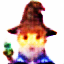

In [ ]:
def generate_latent_representation(image, model):
    model.eval()
    with torch.no_grad():
        output = model.encoder(image.unsqueeze(0))
    return output.squeeze(0)

latent_rep1 = generate_latent_representation(img_tensor1, model)
latent_rep2 = generate_latent_representation(img_tensor2, model)

def perform_vector_arithmetic(latent_rep_1, latent_rep_2, alpha):

    # composite_latent_rep = (1 - alpha) * latent_rep_1 + alpha * latent_rep_2
    composite_latent_rep = latent_rep_1 + latent_rep_2
    return composite_latent_rep


composite_latent_rep = perform_vector_arithmetic(latent_rep1, latent_rep2, 0.5)
# print(composite_latent_rep.shape)

def generate_image_from_latent_rep(composite_latent_rep, model):
    model.eval()
    with torch.no_grad():
        output = model.decoder(composite_latent_rep.unsqueeze(0))
    output = output.squeeze(0)
    output = torch.clamp(output, 0, 1)
    return output

output_image_tensor = generate_image_from_latent_rep(composite_latent_rep, model)

output_image_pil = transforms.ToPILImage()(output_image_tensor.cpu())

output_image_pil